# 1. Data transformation

In [1]:
from src.prediction.cnn.data_transformer import BinaryImageTransformer

transformer = BinaryImageTransformer(
    data_dir="model/data", grid_width=100, grid_resolution=2.0
)

Grid Transformer, option: 
	data_path=model/data
	grid_size=100
	grid_resolution=2.0
	grid_bound=((-50.0, 50.0), (-50.0, 50.0))
	save_path=model/images/grid_100_res_2.0 initialized.


In [2]:
image_tensor = transformer.generate_images()
print(image_tensor.shape)

Output matrix saved at model/data/output_matrix.npy
Loading image matrix from model/images/grid_100_res_2.0/image_matrix.npy
Image matrix loaded from model/images/grid_100_res_2.0/image_matrix.npy
(750, 200, 200)


In [3]:
def plot_img(images_matrix) -> None:
    import matplotlib.pyplot as plt

    for idx, image_matrix in enumerate(images_matrix[0:10]):
        plt.figure(figsize=(3, 3))
        plt.imshow(
            image_matrix,
            cmap="gray",
            # interpolation="nearest",
        )  # Display the image using a grayscale colormap
        plt.title(f"Data : {idx+1}")
        plt.show()


# plot_img(image_tensor)

# 2. Import modules

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import numpy as np
from scipy.stats import spearmanr

import os
from typing import Callable, Union, Literal, Tuple

# 3. Configs and Hyperparameters

## 3.1 Setup configs

In [5]:
# Device configuration: Use GPU if available
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Data path
IMAGE_MATRIX_PATH = transformer.image_matrix_path
OUTPUT_MATRIX_PATH = transformer.output_matrix_path

Using device: mps


## 3.2 Hyperparameters

In [6]:
# Hyperparameters
MINI_BATCH_SIZE = 64
TRAIN_RATIO = 0.75
NUM_EPOCHS = 125
EARLY_STOP_CNT = 10  # inf can be used to disable early stopping e.g) float('inf')
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# 4. Load data set

## 4.1 Define data loader

In [7]:
def get_data_set(
    numpy_tensor_path: str, train_ratio: float, data_type: Literal["image", "tensor"]
) -> dict[Literal["train", "test"], torch.Tensor]:
    """
    Loads data from a .npy file, splits it into training and testing sets,
    and converts them to PyTorch tensors.

    Args:
        numpy_tensor_path (str): Path to the .npy file.
        train_ratio (float): Proportion of data to use for training.
        data_type (Literal["image", "tensor"]): Type of data ("image" or "tensor").

    Returns:
        dict: Dictionary containing 'train' and 'test' tensors.
    """
    # Load .npy data
    data = np.load(
        numpy_tensor_path
    )  # Assuming shape is (batch_size, height, width) or (batch_size, features)
    data_len = len(data)
    split_index = int(data_len * train_ratio)

    # Split data into training and testing
    train_set = data[:split_index]
    test_set = data[split_index:]

    # Convert NumPy arrays to PyTorch tensors
    train_tensor = torch.from_numpy(train_set).float()
    test_tensor = torch.from_numpy(test_set).float()

    if data_type == "image":
        # Add channel dimension for grayscale images: (batch_size, 1, N, N)
        train_tensor = train_tensor.unsqueeze(1)
        test_tensor = test_tensor.unsqueeze(1)

    return {"train": train_tensor, "test": test_tensor}


class PhysicsImageDataset(Dataset):
    """
    Custom Dataset for loading physics-related images and their corresponding targets.
    Applies data augmentation (horizontal flip) to the images.
    """

    def __init__(
        self,
        image_tensor: torch.Tensor,
        output_tensor: torch.Tensor,
        augment: bool = False,
        image_tensor_transformer: Union[
            Callable[[torch.Tensor], torch.Tensor], None
        ] = None,
        output_tensor_transformer: Union[
            Callable[[torch.Tensor], torch.Tensor], None
        ] = None,
    ):
        """
        Args:
            image_tensor (torch.Tensor): Tensor of images with shape (num_samples, 1, N, N).
            output_tensor (torch.Tensor): Tensor of targets with shape (num_samples, 3).
            augment (bool, optional): Whether to apply data augmentation. Defaults to False.
            image_tensor_transformer (Union[Callable[[torch.Tensor], torch.Tensor], None], optional): Transformation function for the image tensor. Defaults to None.
            output_tensor_transformer (Union[Callable[[torch.Tensor], torch.Tensor], None], optional): Transformation function for the output tensor. Defaults to None.
        """
        self.image_tensor = (
            image_tensor
            if image_tensor_transformer is None
            else image_tensor_transformer(image_tensor)
        )
        self.output_tensor = (
            output_tensor
            if output_tensor_transformer is None
            else output_tensor_transformer(output_tensor)
        )
        self.augment = augment
        self.origin_data_size = len(image_tensor)
        self.transform = (
            transforms.Compose(
                [transforms.RandomHorizontalFlip(p=1.0)]  # Always flip when augmenting
            )
            if self.augment
            else None
        )

    def __len__(self):
        # If augmenting, double the dataset size
        return self.origin_data_size * 2 if self.augment else self.origin_data_size

    def __getitem__(self, idx):
        if self.augment and idx >= self.origin_data_size:
            # Augmented sample: flip the image horizontally
            original_idx = idx - self.origin_data_size
            image = self.image_tensor[original_idx]
            image = self.transform(image)
            target = self.output_tensor[original_idx]
        else:
            # Original sample
            image = self.image_tensor[idx]
            target = self.output_tensor[idx]

        return image, target

## 4.2 Data loading process

In [8]:
# Ensure that the data paths exist
if not os.path.exists(IMAGE_MATRIX_PATH):
    raise FileNotFoundError(f"Image data file not found at {IMAGE_MATRIX_PATH}")
if not os.path.exists(OUTPUT_MATRIX_PATH):
    raise FileNotFoundError(f"Output data file not found at {OUTPUT_MATRIX_PATH}")


def ExtractOutputProperty(
    output_tensor: torch.Tensor, property: Literal["drag", "avg_temp", "max_temp"]
) -> torch.Tensor:
    """
    Extracts a specific property from the output tensor.

    Args:
        output_tensor (torch.Tensor): Output tensor with shape (num_samples, num_properties).
        property_idx (int): Index of the property to extract.

    Returns:
        torch.Tensor: Tensor containing the specified property.
    """
    property_map = {"drag": 0, "avg_temp": 1, "max_temp": 2}
    return output_tensor[:, property_map[property]]


# Load image and output data
image_data = get_data_set(
    numpy_tensor_path=IMAGE_MATRIX_PATH,
    train_ratio=TRAIN_RATIO,
    data_type="image",
)
output_data = get_data_set(
    numpy_tensor_path=OUTPUT_MATRIX_PATH,
    train_ratio=TRAIN_RATIO,
    data_type="tensor",
)

# Create training and testing datasets
# Apply data augmentation (flipping) only to the training dataset
train_dataset = PhysicsImageDataset(
    image_tensor=image_data["train"],
    output_tensor=output_data["train"],
    augment=True,  # Enable augmentation for training
    output_tensor_transformer=lambda x: ExtractOutputProperty(x, "avg_temp"),
)
test_dataset = PhysicsImageDataset(
    image_tensor=image_data["test"],
    output_tensor=output_data["test"],
    augment=True,  # No augmentation for testing
    output_tensor_transformer=lambda x: ExtractOutputProperty(x, "avg_temp"),
)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=MINI_BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=MINI_BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)


print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 1124
Number of testing samples: 376


# 5. Model architecture

In [9]:
import torch
import torch.nn as nn


class Model(nn.Module):
    def define_model_name(self, model_name: str) -> None:
        self.model_name = model_name

    def __init__(self):
        super().__init__()

        # Formula :: NewImageSize = (PrevImageSize - KernelSize + 2PaddingSize) / Stride + 1

        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            # @Layer1 = 1x200x200 -> 16x200x200
            nn.ReLU(),
        )

        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            # @Layer2 = 16x200x200 -> 32x200x200
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # @Layer3 = 32x200x200 -> 32x100x100
        )

        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            # @Layer4 = 32x100x100 -> 64x100x100
            nn.ReLU(),
        )

        self.conv_layer_4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            # @Layer6 = 64x100x100 -> 128x100x100
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # @Layer7 = 128x100x100 -> 128x50x50
        )

        self.conv_layer_5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            # @Layer8 = 128x50x50 -> 256x50x50
            nn.ReLU(),
            # @Layer9 = 256x50x50 -> 256x50x50
        )

        self.conv_layer_6 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            # @Layer10 = 256x50x50 -> 512x50x50
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # @Layer11 = 512x50x50 -> 512x25x25
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(512 * 25 * 25, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
        )

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_4(x)
        x = self.conv_layer_5(x)
        x = self.conv_layer_6(x)

        x = x.view(x.size(0), -1)  # Flatten the tensor

        x = self.fc_layer(x)

        return x

In [10]:
from datetime import datetime
import io
import sys
import uuid
import hashlib


def capture_print_output(func, *args, **kwargs):
    # Create a string IO stream to capture the output
    captured_output = io.StringIO()

    # Redirect stdout to the StringIO object
    sys.stdout = captured_output

    # Execute the function
    func(*args, **kwargs)

    # Reset stdout to default
    sys.stdout = sys.__stdout__

    # Get the output from the StringIO object
    output_value = captured_output.getvalue()

    # Close the StringIO stream
    captured_output.close()

    # Return the captured output
    return output_value


def generate_uuid_from_seed(seed_str: str) -> uuid.UUID:
    # Create an MD5 hash from the seed string
    hash_object = hashlib.md5(seed_str.encode())

    # Use the hash to create a UUID
    return uuid.UUID(hash_object.hexdigest())


def create_model_save_storage(
    model_name: str, model_architecture: str, hyperparameter_dict: dict[str, any]
) -> Tuple[str, str, str]:
    """
    Create a dir for model experiment and record the model configuration.

    Args:
        model_name (str): _description_
        model_architecture (str): _description_
        hyperparameter_dict (dict[str, any]): _description_

    Returns:
        str: model save directory path
    """
    # Create a directory to store the model and its explanation
    model_uuid = generate_uuid_from_seed(model_architecture)
    model_dir = f"model/models/{model_name}_{model_uuid}"
    os.makedirs(model_dir, exist_ok=True)

    hyperparameter_description_str = "\n".join(
        [f"> {key} : {value}" for key, value in hyperparameter_dict.items()]
    )

    model_config_path = f"{model_dir}/config.txt"
    model_weight_path = f"{model_dir}/model.pth"

    # Save the model explanation to a text file
    with open(f"{model_dir}/config.txt", "w") as f:
        f.write(f"\n{"-" * 100}\n")
        f.write(f"Generated at : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        f.write("\n")
        f.write(model_name)
        f.write(f"\n{"-" * 100}\n")
        f.write("Hyperparameters\n")
        f.write(hyperparameter_description_str)
        f.write(f"\n{"-" * 100}\n")
        f.write("Model Architecture\n")
        f.write(model_architecture)

    return model_dir, model_config_path, model_weight_path

In [11]:
model = Model().to(device)

# 6. Loss function, Optimizer

In [12]:
# RMSE Loss
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

In [13]:
loss_function = RMSELoss()

optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE
)  # L2 regularization via weight_decay

# 6(Optional). Learning rate scheduler

In [14]:
from torch.optim import lr_scheduler

STEP_SIZE = NUM_EPOCHS / 10
# Use a learning rate scheduler that reduces LR by a factor of 0.1 every 10 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=0.1)

# 7. Training

## 7.1 Initialize model storage

In [15]:
from torchsummary import summary

# Define the model name and save storage
model_name = "cnn_6_fc_2_rmse_avg_temp"
model.define_model_name(model_name)

# Temporary move model to CPU for summary
model_details = capture_print_output(
    summary, model.to("cpu"), input_size=(1, 200, 200), device="cpu"
)

# Back to original device, MPS
# Note, -1 = <batch size> is not fixed.
model.to(device)

# Create model save storage for experiment
model_save_path, model_config_path, model_weight_path = create_model_save_storage(
    model_name=model.model_name,
    model_architecture=model_details,
    hyperparameter_dict={
        "MINI_BATCH_SIZE": MINI_BATCH_SIZE,
        "TRAIN_RATIO": TRAIN_RATIO,
        "NUM_EPOCHS": NUM_EPOCHS,
        "EARLY_STOP_CNT": EARLY_STOP_CNT,
        "LEARNING_RATE": LEARNING_RATE,
        "WEIGHT_DECAY": WEIGHT_DECAY,
        "LOSS_FUNCTION": loss_function.__str__(),
        "OPTIMIZER": optimizer.__str__(),
        # "SCHEDULER": scheduler.__str__(),
    },
)

## 7.2 Training process

In [16]:
def save_model_training_result(
    epoch_end: int,
    train_loss_record: list[float],
    val_loss_record: list[float],
):
    # Save the training result to a text file
    with open(f"{model_save_path}/training_result.json", "w") as f:
        f.write(
            f'{{"epoch_end": {epoch_end}, "train_loss": {train_loss_record}, "val_loss": {val_loss_record}}}'
        )


def plot_loss_curve(
    epoch_end: int, train_loss_record: list[float], val_loss_record: list[float]
):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))

    epoch_end_linspace = np.linspace(0, epoch_end, len(train_loss_record))
    plt.plot(
        epoch_end_linspace,
        train_loss_record,
        label="Train Loss",
        color="blue",
        linestyle="-",
    )
    val_linspace = np.linspace(0, epoch_end, len(val_loss_record))
    plt.plot(
        val_linspace, val_loss_record, label="Val Loss", color="green", linestyle="-"
    )
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Cost Curve (Epochs: {epoch_end}) for model {model_name}")
    plt.grid(True)
    plt.show()

In [17]:
def report_epoch(
    epoch: int,
    learning_rate: float,
    epoch_train_loss,
    epoch_val_loss,
    avg_spearman_corr,
):
    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} | Learning Rate: {learning_rate:.4f} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Avg Spearman: {avg_spearman_corr:.4f}"
    )


def train(
    model,
    train_loader,
    test_loader,
    optimizer,
    loss_function,
    epoch_count: int,
    early_stop_cnt: int,
    learning_scheduler: Union[lr_scheduler.StepLR, None] = None,
) -> Tuple[int, list[float], list[float]]:
    print("Starting training...")

    best_val_loss = float("inf")
    early_stopping_counter = 0

    train_loss_record = []
    val_loss_record = []

    for epoch in range(epoch_count):
        model.train()
        running_train_loss = 0.0
        for inputs, targets in train_loader:
            # Move to GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            predict = model(inputs)
            # Compute loss
            val_loss = loss_function(predict, targets)

            # Backward pass
            val_loss.backward()
            # Optimize
            optimizer.step()
            # Learning rate scheduler if available
            if learning_scheduler is not None:
                learning_scheduler.step()

            # Record the loss
            train_loss = val_loss.item()
            train_loss_record.append(train_loss)

            running_train_loss += train_loss * inputs.size(0)  # Accumulate loss

        epoch_train_loss = running_train_loss / len(train_loader.dataset)

        # Validation phase
        model.eval()  # Freeze the model
        running_val_loss = 0.0
        val_outputs = []
        val_targets = []

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                predict = model(inputs)

                val_loss = loss_function(predict, targets)
                val_loss_record.append(val_loss.item())

                running_val_loss += val_loss.item() * inputs.size(0)

                val_outputs.append(predict.cpu().numpy())
                val_targets.append(targets.cpu().numpy())

        epoch_val_loss = running_val_loss / len(test_loader.dataset)

        # Spearman correlation calc (experiment for G.A)
        # val_outputs_np = np.concatenate(val_outputs, axis=0)
        # val_targets_np = np.concatenate(val_targets, axis=0)

        # spearman_correlation = []
        # for i in range(val_targets_np.shape[1]):
        #     corr, _ = spearmanr(val_targets_np[:, i], val_outputs_np[:, i])
        #     spearman_correlation.append(corr)
        # avg_spearman_corr = np.mean(spearman_correlation)

        # Report the metrics
        report_epoch(
            epoch,
            learning_rate=optimizer.param_groups[0]["lr"],
            epoch_train_loss=epoch_train_loss,
            epoch_val_loss=epoch_val_loss,
            avg_spearman_corr=0,
        )

        # Early stopping Check
        is_new_best = epoch_val_loss < best_val_loss
        if is_new_best:
            best_val_loss = epoch_val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), model_weight_path)
        else:
            early_stopping_counter += 1
            should_stop = early_stopping_counter >= early_stop_cnt
            if should_stop:
                print("Early stopping triggered.")

                return epoch, train_loss_record, val_loss_record

    return epoch, train_loss_record, val_loss_record

In [18]:
final_epoch, train_loss_record, val_loss_record = train(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    loss_function=loss_function,
    epoch_count=NUM_EPOCHS,
    early_stop_cnt=EARLY_STOP_CNT,
    # learning_scheduler=scheduler,
)

Starting training...
Epoch 1/125 | Learning Rate: 0.0010 | Train Loss: 267.5512 | Val Loss: 241.6935 | Avg Spearman: 0.0000
Epoch 2/125 | Learning Rate: 0.0010 | Train Loss: 67.1544 | Val Loss: 42.0053 | Avg Spearman: 0.0000
Epoch 3/125 | Learning Rate: 0.0010 | Train Loss: 33.6143 | Val Loss: 11.1177 | Avg Spearman: 0.0000
Epoch 4/125 | Learning Rate: 0.0010 | Train Loss: 19.2741 | Val Loss: 22.7331 | Avg Spearman: 0.0000
Epoch 5/125 | Learning Rate: 0.0010 | Train Loss: 18.9667 | Val Loss: 24.4699 | Avg Spearman: 0.0000
Epoch 6/125 | Learning Rate: 0.0010 | Train Loss: 24.6772 | Val Loss: 49.9742 | Avg Spearman: 0.0000
Epoch 7/125 | Learning Rate: 0.0010 | Train Loss: 27.4916 | Val Loss: 6.8065 | Avg Spearman: 0.0000
Epoch 8/125 | Learning Rate: 0.0010 | Train Loss: 19.9605 | Val Loss: 23.9596 | Avg Spearman: 0.0000
Epoch 9/125 | Learning Rate: 0.0010 | Train Loss: 15.6951 | Val Loss: 12.8462 | Avg Spearman: 0.0000
Epoch 10/125 | Learning Rate: 0.0010 | Train Loss: 15.2826 | Val Loss

/Users/june/Documents/project/capstone_1/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/june/Documents/project/capstone_1/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/june/Documents/project/capstone_1/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([56])) that is different to the input size (torch.Size([56, 1])). This will likely lead

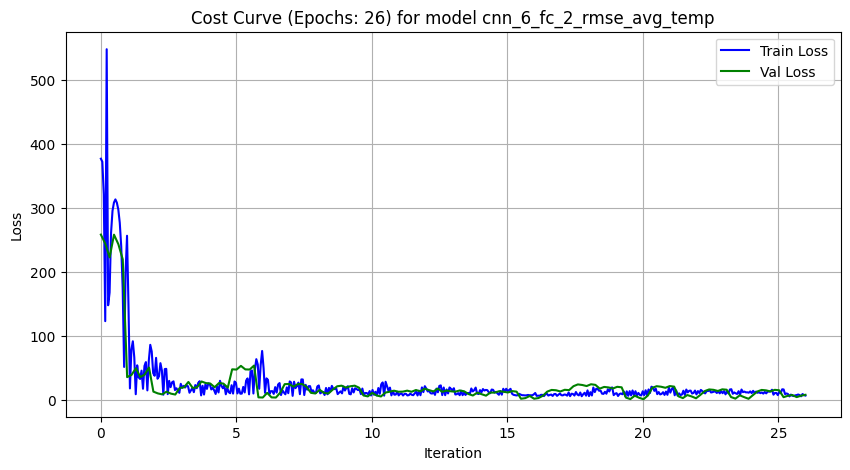

In [19]:
save_model_training_result(final_epoch, train_loss_record, val_loss_record)

plot_loss_curve(
    epoch_end=final_epoch,
    train_loss_record=train_loss_record,
    val_loss_record=val_loss_record,
)

# 8. Evaluation(Validation)

In [20]:
def load_best_model(model) -> None:
    model.load_state_dict(torch.load(model_weight_path))
    model.eval()
    print("Loaded the best model based on validation loss.")


model = Model().to(device)
load_best_model(model)

print(model)

/var/folders/x6/l7qs54m50blbxn2wj8_dbm8m0000gn/T/ipykernel_20899/2951859011.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight

# 9. Inference by test-set

In [21]:
running_val_loss = 0.0
val_outputs = []
val_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        predict = model(inputs)
        print(predict)
        val_loss = loss_function(predict, targets)

        running_val_loss += val_loss.item() * inputs.size(0)

        val_outputs.append(predict.cpu().numpy())
        val_targets.append(targets.cpu().numpy())

final_val_loss = running_val_loss / len(test_loader.dataset)

# Concatenate all outputs and targets for Spearman correlation
val_outputs_np = np.concatenate(val_outputs, axis=0)
val_targets_np = np.concatenate(val_targets, axis=0)

# spearman_correlation = []
# for i in range(val_targets_np.shape[1]):
#     corr, _ = spearmanr(val_targets_np[:, i], val_outputs_np[:, i])
#     spearman_correlation.append(corr)
# final_avg_spearman_corr = np.mean(spearman_correlation)

print(f"Final Validation Loss: {final_val_loss:.4f}")

/Users/june/Documents/project/capstone_1/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/june/Documents/project/capstone_1/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([56])) that is different to the input size (torch.Size([56, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
